<h1>Buffer Analysis and Optimization</h1>

In [1]:
from properties import nr_runs, l_min_pmos, w_min_pmos, l_min_nmos, w_min_nmos, S1, S2, S_LOAD, tran, rit_models, save_s1, save_s2, energy_connected, energy_disconnected, rise_delay_connected, rise_delay_disconnected, fall_delay_connected, fall_delay_disconnected
from utils.conversion import to_order, Order
from utils.paths import ltspice, images
from utils.patterns import s1_pattern, s2_pattern, energy_connected_pattern, energy_disconnected_pattern, rise_delay_connected_pattern, fall_delay_connected_pattern, rise_delay_disconnected_pattern, fall_delay_disconnected_pattern
from utils.check import check_file, check_image
from optimization.optimize_function import optimize_considering_delay
from PyLTSpice import RawRead, SimRunner, SpiceEditor
import re
import statistics as st
import matplotlib.pyplot as plt
import os
from IPython.display import Image, display

<h2>Buffer Analysis</h2>

File opened successfully: ../../ltspice/buffer/standard/buffer.raw
File opened successfully: ../../ltspice/buffer/standard/buffer.asc


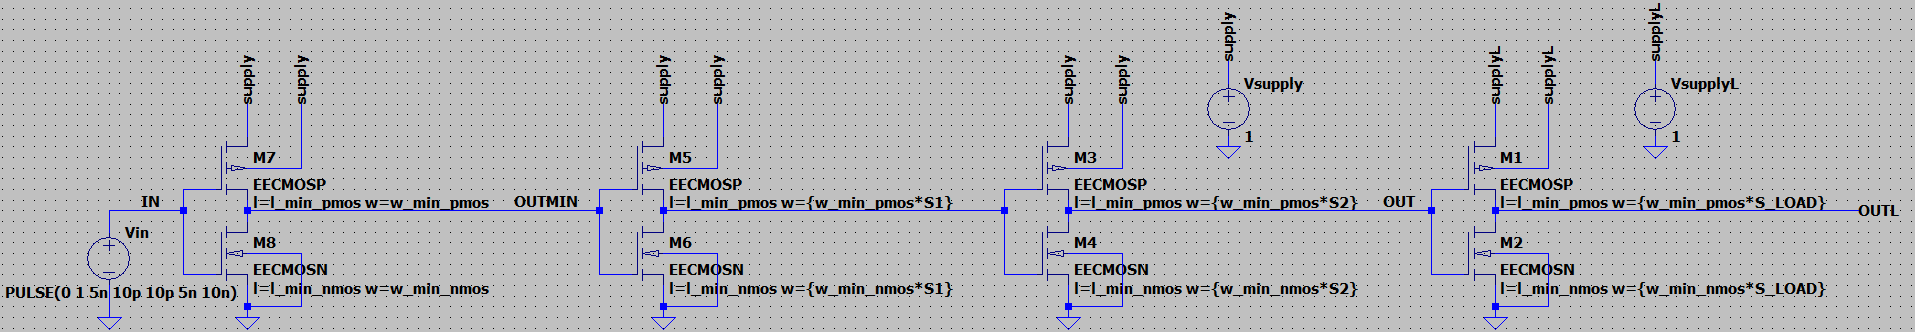

In [2]:
buffer_raw_file_path = os.path.join(ltspice, "buffer/standard/buffer.raw")
check_file(buffer_raw_file_path)
buffer_ltr = RawRead(buffer_raw_file_path)

buffer_asc_file_path = os.path.join(ltspice, "buffer/standard/buffer.asc")
check_file(buffer_asc_file_path)
buffer_netlist = SpiceEditor(buffer_asc_file_path)

buffer_image_path = os.path.join(images, "buffer.png")
display(Image(buffer_image_path))

In [3]:
buffer_netlist.set_parameter('l_min_pmos', l_min_pmos)
buffer_netlist.set_parameter('w_min_pmos', w_min_pmos)
buffer_netlist.set_parameter('l_min_nmos', l_min_nmos)
buffer_netlist.set_parameter('w_min_nmos', w_min_nmos)
buffer_netlist.set_parameter('S1', S1)
buffer_netlist.set_parameter('S2', S2)
buffer_netlist.set_parameter('S_LOAD', S_LOAD)
buffer_netlist.add_instructions(
                                rit_models,
                                tran,
                                f".step param run 1 {nr_runs} 1",
                                save_s1,
                                save_s2,
                                energy_connected(13, 22),
                                rise_delay_connected(),
                                fall_delay_connected()
                        )
buffer_runner = SimRunner(output_folder="data/buffer/standard/")
buffer_runner.run(netlist=buffer_netlist, timeout=3600)
print('Successful/Total Simulations: ' + str(buffer_runner.okSim) + '/' + str(buffer_runner.runno))

buffer_log = ""
for buffer_raw, buffer_log in buffer_runner:
    print("Raw file: %s, Log file: %s" % (buffer_raw, buffer_log))

Wed Nov  8 00:24:39 2023 info: RunTask #1:: Starting simulation 1

Successful/Total Simulations: 0/1
Wed Nov  8 00:24:54 2023 info: RunTask #1:Simulation Successful. Time elapsed: 15.0121 secs

Wed Nov  8 00:24:54 2023 info: RunTask #1:Simulation Finished. No Callback function given

Raw file: data\buffer\standard\buffer_1.raw, Log file: data\buffer\standard\buffer_1.log


File updated successfully: ../../images/buffer_simulation.png


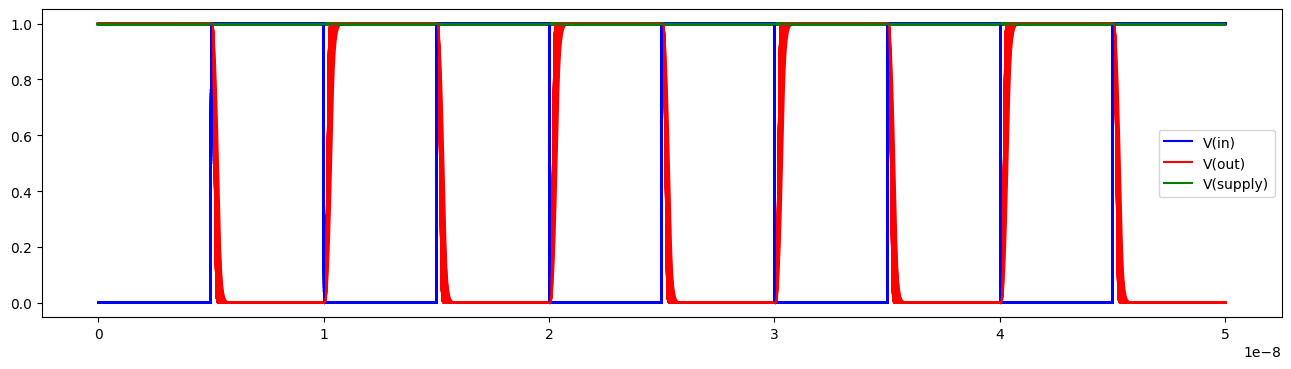

In [4]:
v_in_buffer = buffer_ltr.get_trace("V(in)")
v_out_buffer = buffer_ltr.get_trace("V(out)")
v_supply_buffer = buffer_ltr.get_trace("V(supply)")
time = buffer_ltr.get_trace('time')
steps = buffer_ltr.get_steps()

plt.figure(figsize=(16, 4))
for step in range(len(steps)):
    plt.plot(time.get_wave(step), v_in_buffer.get_wave(step), label=steps[step], color='blue')
    plt.plot(time.get_wave(step), v_out_buffer.get_wave(step), label=steps[step], color='red')
    plt.plot(time.get_wave(step), v_supply_buffer.get_wave(step), label=steps[step], color='green')
plt.legend(["V(in)", "V(out)", "V(supply)"])
buffer_simulation_path_image = os.path.join(images, "buffer_simulation.png")
check_image(buffer_simulation_path_image)
plt.savefig(buffer_simulation_path_image)
plt.show()

File updated successfully: ../../images/s1_s2_montecarlo_trend.png


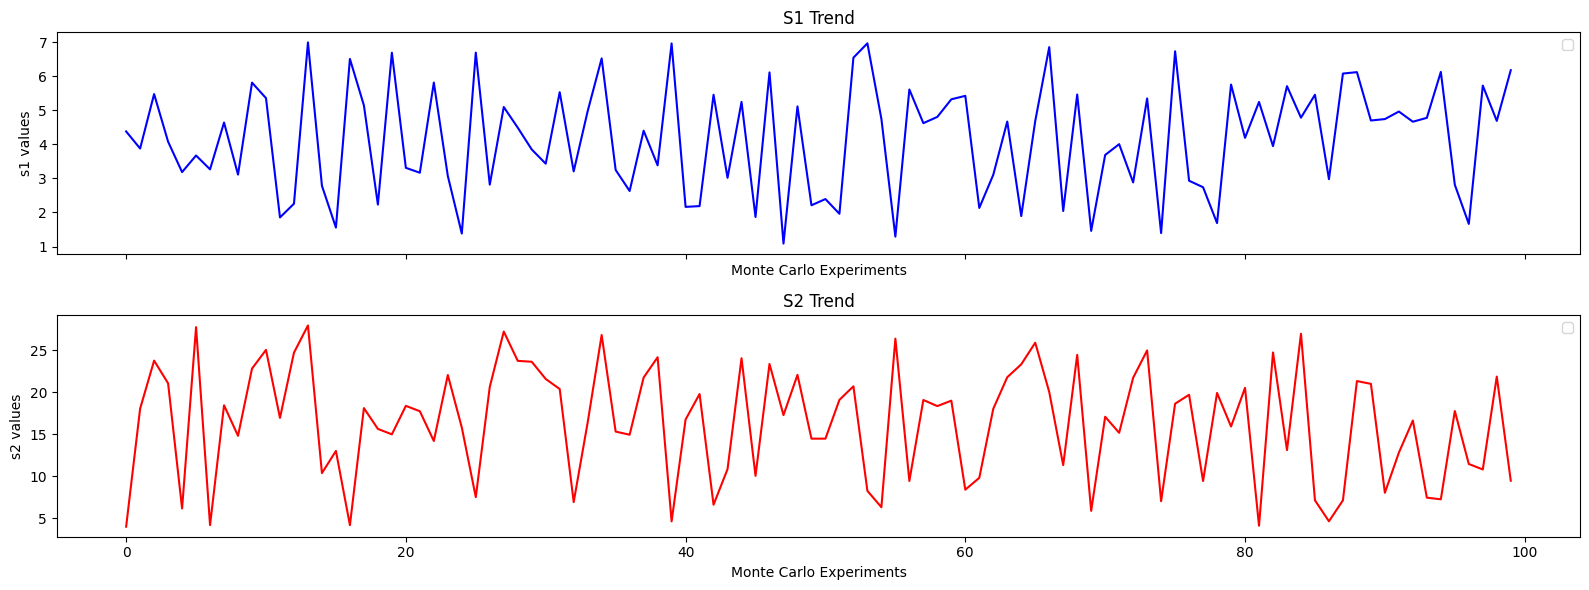

In [5]:
buffer_log_file_path = f"./{buffer_log}"

with open(buffer_log_file_path, "r") as file:
    content = file.read()

s1_data = re.search(s1_pattern, content, re.DOTALL).group(1)
s2_data = re.search(s2_pattern, content, re.DOTALL).group(1)
energy_connected_buffer_data = re.search(energy_connected_pattern, content, re.DOTALL).group(1)
rise_delay_connected_buffer_data = re.search(rise_delay_connected_pattern, content, re.DOTALL).group(1)
fall_delay_connected_buffer_data = re.search(fall_delay_connected_pattern, content, re.DOTALL).group(1)

s1_lines = s1_data.strip().split('\n')[1:]
s2_lines = s2_data.strip().split('\n')[1:]
energy_connected_buffer_lines = energy_connected_buffer_data.strip().split('\n')[1:]
rise_delay_connected_buffer_lines = rise_delay_connected_buffer_data.strip().split('\n')[1:]
fall_delay_connected_buffer_lines = fall_delay_connected_buffer_data.strip().split('\n')[1:]

s1 = [float(line.split('\t')[1]) for line in s1_lines]
s2 = [float(line.split('\t')[1]) for line in s2_lines]
energy_connected_buffer = [float(line.split('\t')[1]) for line in energy_connected_buffer_lines]
energy_connected_buffer = [abs(energy) for energy in energy_connected_buffer]
rise_delay_connected_buffer = [float(line.split('\t')[1]) for line in rise_delay_connected_buffer_lines]
fall_delay_connected_buffer = [float(line.split('\t')[1]) for line in fall_delay_connected_buffer_lines]
delay_connected_buffer = rise_delay_connected_buffer
    
fig, (plt1, plt2) = plt.subplots(2, 1, sharex=True, figsize=(16, 6))
plt1.legend(['S1']); plt2.legend(['S2'])
plt1.plot(s1, label='s1', color='b')
plt1.set_ylabel('s1 values'); plt1.set_xlabel('Monte Carlo Experiments'); plt1.set_title('S1 Trend')
plt2.plot(s2, label='s2', color='r')
plt2.set_xlabel('Monte Carlo Experiments'); plt2.set_ylabel('s2 values'); plt2.set_title('S2 Trend')
plt.tight_layout()
s1_s2_montecarlo_trend_path_image = os.path.join(images, "s1_s2_montecarlo_trend.png")
check_image(s1_s2_montecarlo_trend_path_image)
plt.savefig(s1_s2_montecarlo_trend_path_image)
plt.show()

<h2>Minimum Inverter Connected Analysis</h2>

File opened successfully: ../../ltspice/minimum-inverter/connected/minimum_inverter_connected.raw
File opened successfully: ../../ltspice/minimum-inverter/connected/minimum_inverter_connected.asc


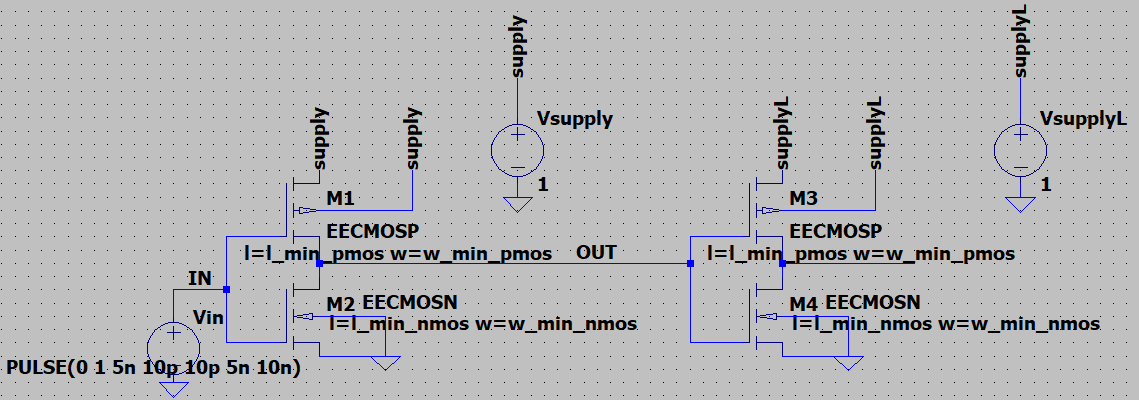

In [6]:
minimum_inverter_connected_raw_file_path = os.path.join(ltspice, "minimum-inverter/connected/minimum_inverter_connected.raw")
check_file(minimum_inverter_connected_raw_file_path)
minimum_inverter_connected_ltr = RawRead(minimum_inverter_connected_raw_file_path)

minimum_inverter_connected_asc_file_path = os.path.join(ltspice, "minimum-inverter/connected/minimum_inverter_connected.asc")
check_file(minimum_inverter_connected_asc_file_path)
minimum_inverter_connected_netlist = SpiceEditor(minimum_inverter_connected_asc_file_path)

minimum_inverter_connected_image_path = os.path.join(images, "minimum_inverter_connected.png")
display(Image(minimum_inverter_connected_image_path))

In [7]:
minimum_inverter_connected_netlist.set_parameter('l_min_pmos', l_min_pmos)
minimum_inverter_connected_netlist.set_parameter('w_min_pmos', w_min_pmos)
minimum_inverter_connected_netlist.set_parameter('l_min_nmos', l_min_nmos)
minimum_inverter_connected_netlist.set_parameter('w_min_nmos', w_min_nmos)
minimum_inverter_connected_netlist.add_instructions(
                                rit_models,
                                tran,
                                ".step param run 1 2 1",
                                energy_connected(18, 22),
                                rise_delay_connected(),
                                fall_delay_connected()
                        )
minimum_inverter_connected_runner = SimRunner(output_folder="data/minimum-inverter/connected/")
minimum_inverter_connected_runner.run(minimum_inverter_connected_netlist)

minimum_inverter_connected_log = ""
for minimum_inverter_connected_raw, minimum_inverter_connected_log in minimum_inverter_connected_runner:
    print("Raw file: %s, Log file: %s" % (minimum_inverter_connected_raw, minimum_inverter_connected_log))

Wed Nov  8 00:25:01 2023 info: RunTask #1:: Starting simulation 1
Wed Nov  8 00:25:03 2023 info: RunTask #1:Simulation Successful. Time elapsed: 02.0564 secs

Wed Nov  8 00:25:03 2023 info: RunTask #1:Simulation Finished. No Callback function given

Raw file: data\minimum-inverter\connected\minimum_inverter_connected_1.raw, Log file: data\minimum-inverter\connected\minimum_inverter_connected_1.log


In [8]:
minimum_inverter_connected_log_file_path = f"./{minimum_inverter_connected_log}"

with open(minimum_inverter_connected_log_file_path, "r") as file:
    content = file.read()

energy_connected_minimum_inverter_data = re.search(energy_connected_pattern, content, re.DOTALL).group(1)
rise_delay_connected_minimum_inverter_data = re.search(rise_delay_connected_pattern, content, re.DOTALL).group(1)
fall_delay_connected_minimum_inverter_data = re.search(fall_delay_connected_pattern, content, re.DOTALL).group(1)

energy_connected_minimum_inverter_lines = energy_connected_minimum_inverter_data.strip().split('\n')[1:]
rise_delay_connected_minimum_inverter_lines = rise_delay_connected_minimum_inverter_data.strip().split('\n')[1:]
fall_delay_connected_minimum_inverter_lines = fall_delay_connected_minimum_inverter_data.strip().split('\n')[1:]

energy_connected_minimum_inverter = [float(line.split('\t')[1]) for line in energy_connected_minimum_inverter_lines]
energy_connected_minimum_inverter = [abs(energy) for energy in energy_connected_minimum_inverter]
rise_delay_connected_minimum_inverter = [float(line.split('\t')[1]) for line in rise_delay_connected_minimum_inverter_lines]
fall_delay_connected_minimum_inverter = [float(line.split('\t')[1]) for line in fall_delay_connected_minimum_inverter_lines]

<h2>Minimum Inverter Disconnected Analysis</h2>

File opened successfully: ../../ltspice/minimum-inverter/disconnected/minimum_inverter_disconnected.raw
File opened successfully: ../../ltspice/minimum-inverter/disconnected/minimum_inverter_disconnected.asc


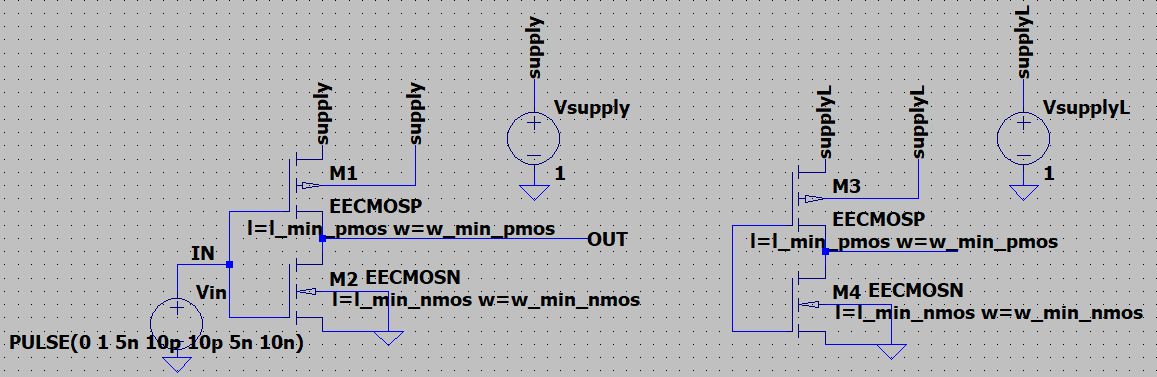

In [9]:
minimum_inverter_disconnected_raw_file_path = os.path.join(ltspice, "minimum-inverter/disconnected/minimum_inverter_disconnected.raw")
check_file(minimum_inverter_disconnected_raw_file_path)
minimum_inverter_disconnected_ltr = RawRead(minimum_inverter_disconnected_raw_file_path)

minimum_inverter_disconnected_asc_file_path = os.path.join(ltspice, "minimum-inverter/disconnected/minimum_inverter_disconnected.asc")
check_file(minimum_inverter_disconnected_asc_file_path)
minimum_inverter_disconnected_netlist = SpiceEditor(minimum_inverter_disconnected_asc_file_path)

minimum_inverter_disconnected_image_path = os.path.join(images, "minimum_inverter_disconnected.png")
display(Image(minimum_inverter_disconnected_image_path))

In [10]:
minimum_inverter_disconnected_netlist.set_parameter('l_min_pmos', l_min_pmos)
minimum_inverter_disconnected_netlist.set_parameter('w_min_pmos', w_min_pmos)
minimum_inverter_disconnected_netlist.set_parameter('l_min_nmos', l_min_nmos)
minimum_inverter_disconnected_netlist.set_parameter('w_min_nmos', w_min_nmos)
minimum_inverter_disconnected_netlist.add_instructions(
                                rit_models,
                                tran,
                                ".step param run 1 2 1",
                                energy_disconnected(18, 22),
                                rise_delay_disconnected(),
                                fall_delay_disconnected()
                        )
minimum_inverter_disconnected_runner = SimRunner(output_folder="data/minimum-inverter/disconnected/")
minimum_inverter_disconnected_runner.run(minimum_inverter_disconnected_netlist)

minimum_inverter_disconnected_log = ""
for minimum_inverter_disconnected_raw, minimum_inverter_disconnected_log in minimum_inverter_disconnected_runner:
    print("Raw file: %s, Log file: %s" % (minimum_inverter_disconnected_raw, minimum_inverter_disconnected_log))

Wed Nov  8 00:25:06 2023 info: RunTask #1:: Starting simulation 1
Wed Nov  8 00:25:08 2023 info: RunTask #1:Simulation Successful. Time elapsed: 02.0490 secs

Wed Nov  8 00:25:08 2023 info: RunTask #1:Simulation Finished. No Callback function given

Raw file: data\minimum-inverter\disconnected\minimum_inverter_disconnected_1.raw, Log file: data\minimum-inverter\disconnected\minimum_inverter_disconnected_1.log


In [11]:
minimum_inverter_disconnected_log_file_path = f"./{minimum_inverter_disconnected_log}"

with open(minimum_inverter_disconnected_log_file_path, "r") as file:
    content = file.read()

energy_disconnected_minimum_inverter_data = re.search(energy_disconnected_pattern, content, re.DOTALL).group(1)
rise_delay_disconnected_minimum_inverter_data = re.search(rise_delay_disconnected_pattern, content, re.DOTALL).group(1)
fall_delay_disconnected_minimum_inverter_data = re.search(fall_delay_disconnected_pattern, content, re.DOTALL).group(1)

energy_disconnected_minimum_inverter_lines = energy_disconnected_minimum_inverter_data.strip().split('\n')[1:]
rise_delay_disconnected_minimum_inverter_lines = rise_delay_disconnected_minimum_inverter_data.strip().split('\n')[1:]
fall_delay_disconnected_minimum_inverter_lines = fall_delay_disconnected_minimum_inverter_data.strip().split('\n')[1:]

energy_disconnected_minimum_inverter = [float(line.split('\t')[1]) for line in energy_disconnected_minimum_inverter_lines]
energy_disconnected_minimum_inverter = [abs(energy) for energy in energy_disconnected_minimum_inverter]
rise_delay_disconnected_minimum_inverter = [float(line.split('\t')[1]) for line in rise_delay_disconnected_minimum_inverter_lines]
fall_delay_disconnected_minimum_inverter = [float(line.split('\t')[1]) for line in fall_delay_disconnected_minimum_inverter_lines]
delay_disconnected_minimum_inverter = rise_delay_disconnected_minimum_inverter

<h2>Overall Buffer Analysis via Monte Carlo Experiments</h2>

File updated successfully: ../../images/montecarlo_experiments.png


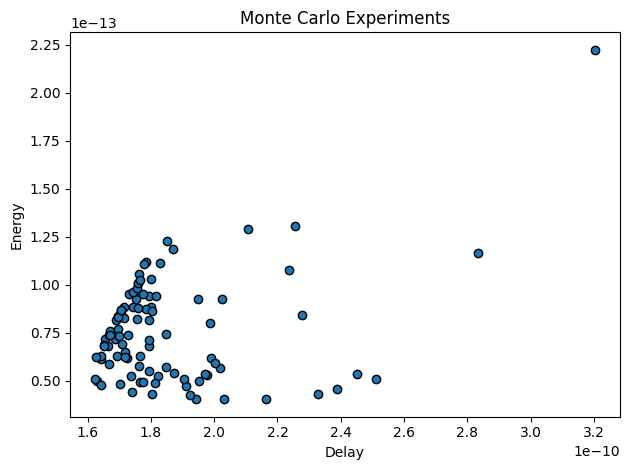

In [12]:
plt.scatter(delay_connected_buffer, energy_connected_buffer, edgecolors='black')
plt.xlabel('Delay'); plt.ylabel('Energy'); plt.title('Monte Carlo Experiments')
plt.tight_layout()
scatter_montecarlo_experiments_path_image = os.path.join(images, "montecarlo_experiments.png")
check_image(scatter_montecarlo_experiments_path_image)
plt.savefig(scatter_montecarlo_experiments_path_image)
plt.show()

In [13]:
vdd = 1
c_tot = [energy / (vdd*vdd) for energy in energy_connected_minimum_inverter]
c_out = [energy / (vdd*vdd) for energy in energy_disconnected_minimum_inverter]
c_in = [c_tot - c_out for c_tot, c_out in zip(c_tot, c_out)]
c_min = c_in[0]
print(f"c_min = {c_min}")
c_min_for_optimization = to_order(c_min, Order.FEMTO)
print(f"c_min_for_optimization = {c_min_for_optimization}")
gamma_e = [c_out / c_in for c_out, c_in in zip(c_out, c_in)]
print(f"gamma_e_max = {max(gamma_e)}")
print(f"gamma_e_min = {min(gamma_e)}")
gamma_e = st.mean(gamma_e)
print(f"gamma_e = {gamma_e}")

c_min = 7.898e-16
c_min_for_optimization = 0.7898
gamma_e_max = 0.6597872879209926
gamma_e_min = 0.6597872879209926
gamma_e = 0.6597872879209926


In [14]:
tau_nom = delay_disconnected_minimum_inverter
tau_nom = st.mean(tau_nom)
print(f"tau_nom = {tau_nom}")
tau_nom_for_optimization = to_order(tau_nom, Order.PICO)
print(f"tau_nom_for_optimization = {tau_nom_for_optimization}")
tau_tot = delay_connected_buffer
s_load = 50
temp1 = [tau_nom / (tau_tot-(3*tau_nom)) for tau_tot in tau_tot]
temp2 = [s1 + (s2/s1) + (s_load/s2) for s1, s2 in zip(s1, s2)]
gamma_d =  [tmp1 * tmp2 for tmp1, tmp2 in zip(temp1, temp2)]
print(f"gamma_d_max = {max(gamma_d)}")
print(f"gamma_d_min = {min(gamma_d)}")
gamma_d = st.mean( gamma_d )
print(f"gamma_d = {gamma_d}")

tau_nom = 7.86338e-12
tau_nom_for_optimization = 7.86338
gamma_d_max = 0.6696729030251873
gamma_d_min = 0.6022287018841667
gamma_d = 0.6304836168099743


<h1>Optmization</h1>

D:\Disco D\universita\magistrale\progettazione-low-power\progetti\progetto-1\python\buffer-analysis\optimization\optimize_function.py:8: OptimizeWarning: Unknown solver options: maxfun, gtol
  result = minimize(energy, s0, args=(gamma_e, vdd, c_min, s_load), constraints=delay_constraints, method='SLSQP',


File updated successfully: ../../images/s1_s2_optimized.png


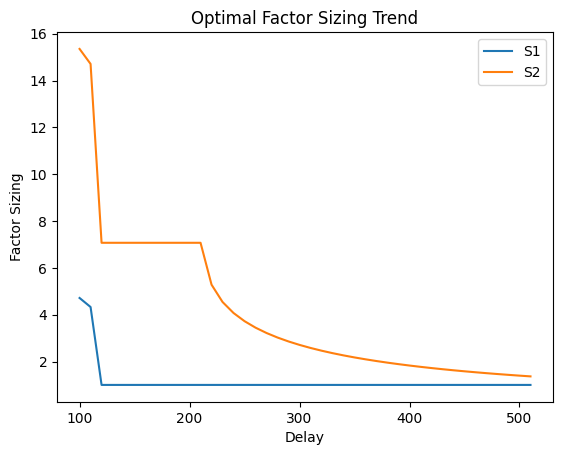

delay      optimal_point                  objective_f_value                   iterations     
510        [1.         1.36479905]        43.11111507166737                   11             
500        [1.       1.396576]            43.152771473304234                  12             
490        [1.         1.42993269]        43.19649876067408                   14             
480        [1.         1.46499449]        43.242461277573454                  11             
470        [1.         1.50190219]        43.290843579043006                  11             
460        [1.         1.54080429]        43.34184034339876                   10             
450        [1.         1.58189849]        43.395710724898194                  10             
440        [1.         1.62536831]        43.45269532205495                   11             
430        [1.        1.6714362]          43.51308571730031                   10             
420        [1.         1.72034733]        43.577203309365046

In [15]:
optimal_results = []

c_min = c_min_for_optimization
tau_nom = tau_nom_for_optimization
s0 = [10, 10]
max_iter = 10000

var1_values = []
var2_values = []
delay_values = []

d_max = 510
d_min = 100
step = 10

for delay in range(d_max, d_min - 1, -step):
    variables, energy_value, iteration_count = optimize_considering_delay(delay, tau_nom, gamma_d, s_load, vdd, c_min, gamma_e, s0, max_iter)
    optimal_results.append((delay, variables, energy_value, iteration_count))
    
    var1_values.append(variables[0])
    var2_values.append(variables[1])
    delay_values.append(delay)

plt.plot(delay_values, var1_values, label='S1')
plt.plot(delay_values, var2_values, label='S2')
plt.legend()
plt.xlabel('Delay'); plt.ylabel('Factor Sizing'); plt.title('Optimal Factor Sizing Trend')
s1_s2_optimized_path_image = os.path.join(images, "s1_s2_optimized.png")
check_image(s1_s2_optimized_path_image)
plt.savefig(s1_s2_optimized_path_image)
plt.show()

print("{:<10} {:<30} {:<35} {:<15}".format("delay", "optimal_point", "objective_f_value", "iterations"))
for delay, variables, energy_value, iteration_count in optimal_results:
    print("{:<10} {:<30} {:<35} {:<15}".format(delay, str(variables), energy_value, iteration_count))

<h2>Comparative Analysis</h2>

File opened successfully: ../../ltspice/buffer/optimized/buffer_optimized.raw
File opened successfully: ../../ltspice/buffer/optimized/buffer_optimized.asc


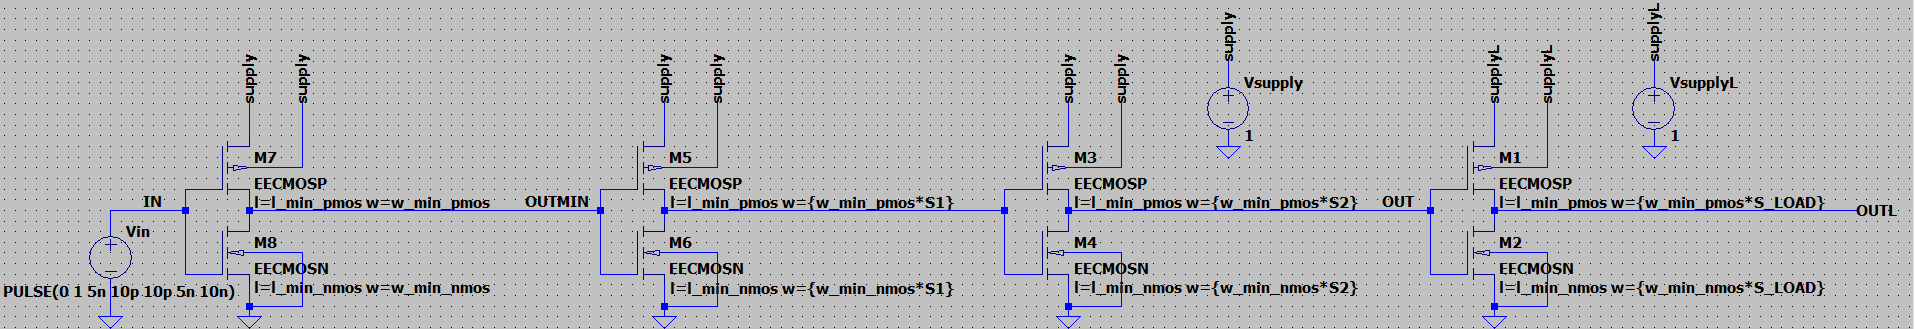

In [16]:
buffer_optimized_raw_file_path = os.path.join(ltspice, "buffer/optimized/buffer_optimized.raw")
check_file(buffer_optimized_raw_file_path)
buffer_optimized_ltr = RawRead(buffer_optimized_raw_file_path)

buffer_optimized_asc_file_path = os.path.join(ltspice, "buffer/optimized/buffer_optimized.asc")
check_file(buffer_optimized_asc_file_path)
buffer_optimized_netlist = SpiceEditor(buffer_optimized_asc_file_path)

buffer_optimized_image_path = os.path.join(images, "buffer_optimized.png")
display(Image(buffer_optimized_image_path))

In [17]:
n_runs_optimized = ((d_max - d_min)/step) + 1

tmp_s1 = [(str(var1)+"," if var1!=var1_values[len(var1_values)-1] else str(var1)) for var1 in var1_values]
s1_table_optimized = ""
for item in tmp_s1:
    s1_table_optimized = s1_table_optimized + item
tmp_s2 = [(str(var2)+"," if var2!=var2_values[len(var2_values)-1] else str(var2)) for var2 in var2_values]
s2_table_optimized = ""
for item in tmp_s2:
    s2_table_optimized = s2_table_optimized + item

S1_optimized = f' table(index,{s1_table_optimized})'
S2_optimized = f' table(index,{s2_table_optimized})'

buffer_optimized_netlist.set_parameter('l_min_pmos', l_min_pmos)
buffer_optimized_netlist.set_parameter('w_min_pmos', w_min_pmos)
buffer_optimized_netlist.set_parameter('l_min_nmos', l_min_nmos)
buffer_optimized_netlist.set_parameter('w_min_nmos', w_min_nmos)
buffer_optimized_netlist.set_parameter('S1', S1_optimized)
buffer_optimized_netlist.set_parameter('S2', S2_optimized)
buffer_optimized_netlist.set_parameter('S_LOAD', S_LOAD)
buffer_optimized_netlist.add_instructions(
                                rit_models,
                                tran,
                                f".step param index 1 {n_runs_optimized} 1",
                                energy_connected(13,22),
                                rise_delay_connected(),
                                fall_delay_connected()
                        )
buffer_optimized_runner = SimRunner(output_folder="data/buffer/optimized/")
buffer_optimized_runner.run(buffer_optimized_netlist)

buffer_optimized_log = ""
for buffer_optimized_raw, buffer_optimized_log in buffer_optimized_runner:
    print("Raw file: %s, Log file: %s" % (buffer_optimized_raw, buffer_optimized_log))

Wed Nov  8 00:25:23 2023 info: RunTask #1:: Starting simulation 1
Wed Nov  8 00:25:31 2023 info: RunTask #1:Simulation Successful. Time elapsed: 08.0030 secs

Wed Nov  8 00:25:31 2023 info: RunTask #1:Simulation Finished. No Callback function given

Raw file: data\buffer\optimized\buffer_optimized_1.raw, Log file: data\buffer\optimized\buffer_optimized_1.log


File updated successfully: ../../images/buffer_optimized_simulation.png


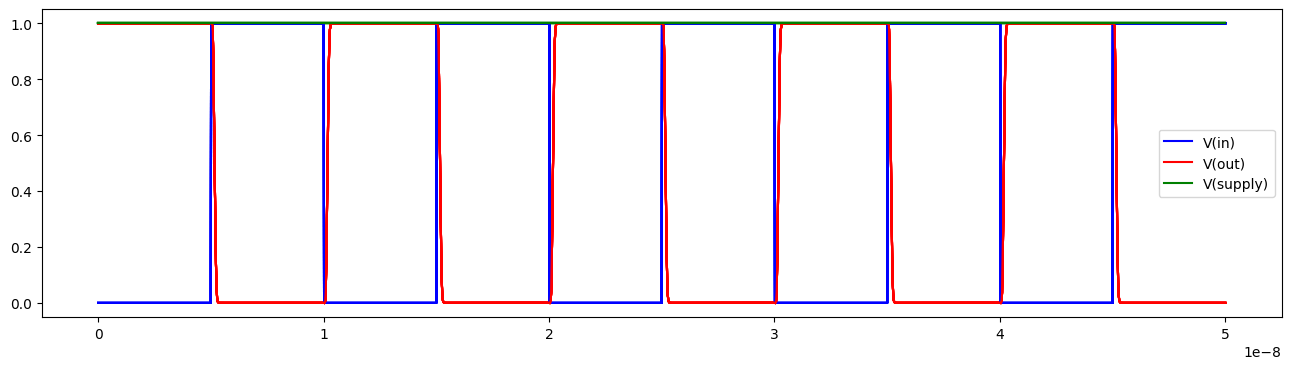

In [18]:
v_in_buffer_optimized = buffer_optimized_ltr.get_trace("V(in)")
v_out_buffer_optimized = buffer_optimized_ltr.get_trace("V(out)")
v_supply_buffer_optimized = buffer_optimized_ltr.get_trace("V(supply)")
time = buffer_optimized_ltr.get_trace('time')
steps = buffer_optimized_ltr.get_steps()

plt.figure(figsize=(16, 4))
for step in range(len(steps)):
    plt.plot(time.get_wave(step), v_in_buffer_optimized.get_wave(step), label=steps[step], color='blue')
    plt.plot(time.get_wave(step), v_out_buffer_optimized.get_wave(step), label=steps[step], color='red')
    plt.plot(time.get_wave(step), v_supply_buffer_optimized.get_wave(step), label=steps[step], color='green')
plt.legend(["V(in)", "V(out)", "V(supply)"])
buffer_optimized_simulation_path_image = os.path.join(images, "buffer_optimized_simulation.png")
check_image(buffer_optimized_simulation_path_image)
plt.savefig(buffer_optimized_simulation_path_image)
plt.show()

In [19]:
buffer_optimized_log_file_path = f"./{buffer_optimized_log}"

with open(buffer_optimized_log_file_path, "r") as file:
    content = file.read()

energy_connected_buffer_optimized_data = re.search(energy_connected_pattern, content, re.DOTALL).group(1)
rise_delay_connected_buffer_optimized_data = re.search(rise_delay_connected_pattern, content, re.DOTALL).group(1)
fall_delay_connected_buffer_optimized_data = re.search(fall_delay_connected_pattern, content, re.DOTALL).group(1)

energy_connected_buffer_optimized_lines = energy_connected_buffer_optimized_data.strip().split('\n')[1:]
rise_delay_connected_buffer_optimized_lines = rise_delay_connected_buffer_optimized_data.strip().split('\n')[1:]
fall_delay_connected_buffer_optimized_lines = fall_delay_connected_buffer_optimized_data.strip().split('\n')[1:]

energy_connected_buffer_optimized = [float(line.split('\t')[1]) for line in energy_connected_buffer_optimized_lines]
energy_connected_buffer_optimized = [abs(energy) for energy in energy_connected_buffer_optimized]
rise_delay_connected_buffer_optimized = [float(line.split('\t')[1]) for line in rise_delay_connected_buffer_optimized_lines]
fall_delay_connected_buffer_optimized = [float(line.split('\t')[1]) for line in fall_delay_connected_buffer_optimized_lines]
delay_connected_buffer_optimized = rise_delay_connected_buffer_optimized

File updated successfully: ../../images/energy_delay_curve.png


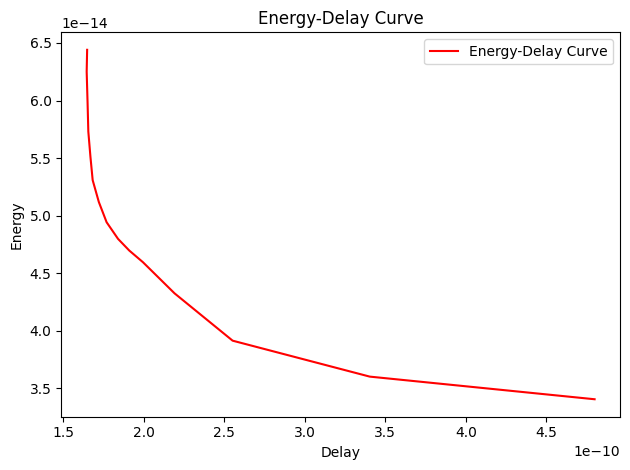

In [20]:
plt.plot(delay_connected_buffer_optimized, energy_connected_buffer_optimized, color='red')
plt.xlabel('Delay'); plt.ylabel('Energy'); plt.title('Energy-Delay Curve')
plt.tight_layout()
plt.legend(["Energy-Delay Curve"])
energy_delay_curve_path_image = os.path.join(images, "energy_delay_curve.png")
check_image(energy_delay_curve_path_image)
plt.savefig(energy_delay_curve_path_image)
plt.show()

File updated successfully: ../../images/comparative_analysis.png


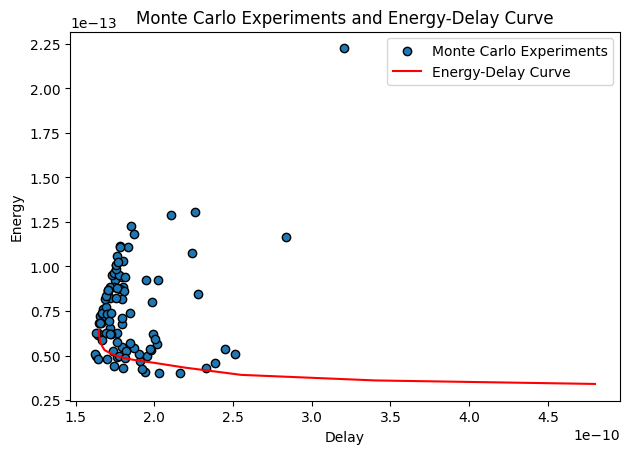

In [21]:
plt.scatter(delay_connected_buffer, energy_connected_buffer, edgecolors='black')
plt.plot(delay_connected_buffer_optimized, energy_connected_buffer_optimized, color='red')
plt.xlabel('Delay'); plt.ylabel('Energy'); plt.title('Monte Carlo Experiments and Energy-Delay Curve')
plt.tight_layout()
plt.legend(["Monte Carlo Experiments", "Energy-Delay Curve"])
comparative_analysis_path_image = os.path.join(images, "comparative_analysis.png")
check_image(comparative_analysis_path_image)
plt.savefig(comparative_analysis_path_image)
plt.show()

<h1>To MATLAB</h1>

In [22]:
data_to_matlab_directory = "../../matlab/"
data_to_matlab_file = "buffer_data.txt"
data_to_matlab_file_path = os.path.join(data_to_matlab_directory, data_to_matlab_file)

with open(data_to_matlab_file_path, "w") as file:
    file.truncate(0)
    file.write(f"{vdd}\n")
    file.write(f"{c_min}\n")
    file.write(f"{gamma_e}\n")
    file.write(f"{tau_nom}\n")
    file.write(f"{gamma_d}\n")
    file.write(f"{S_LOAD}\n")
    file.write(f"{s0[0]}\n")
    file.write(f"{s0[1]}\n")
    file.write(f"{d_max}\n")
    file.write(f"{d_min}\n")

print(f"Variables written successfully: {data_to_matlab_file_path}")


Variables written successfully: ../../matlab/buffer_data.txt


<h1>From MATLAB</h1>
<strong>At this point you need to open MATLAB and run the '../../matlab/optimization' script so as to generate the optimized values of the sizing factors S1 and S2 and make a comparison between those generated by the 'fmincon' optimization algorithm present in MATLAB and those generated by the algorithm scipy.minimize optimization tool of type 'SLSQP'. Therefore, you will be asked if you can continue with the execution. This will only be possible by entering the word 'continue' in the popup window which will indicate that the MATLAB script has been executed and you can continue with the execution of the Jupyter notebook. Obviously this popup window is indicative. So much so that in the case of invalid input, execution continues as the exception is caught and handled. It is just to remind the user that before executing the next code it is necessary to execute the MATLAB script '../../matlab/optimization' because otherwise there would be a risk of generating errors or inconsistent results.</strong>

In [23]:
try:
    user_input = input("Write 'continue' if and only if the MATLAB script has been launched: ")
    if user_input.lower() == 'continue':
        print("You entered 'continue'. The execution continues.")
    else:
        raise ValueError("Input other than 'continue'. Execution stopped.")
except ValueError as e:
    print("Error:", e)


You entered 'continue'. The execution continues.


In [24]:
data_from_matlab_directory = "../../matlab/data"
s1_data_from_matlab_file = "s1_data.txt"
s2_data_from_matlab_file = "s2_data.txt"
s1_data_from_matlab_file_path = os.path.join(data_from_matlab_directory, s1_data_from_matlab_file)
s2_data_from_matlab_file_path = os.path.join(data_from_matlab_directory, s2_data_from_matlab_file)
with open(s1_data_from_matlab_file_path, 'r') as s1_file:
    s1_lines = s1_file.readlines()
with open(s2_data_from_matlab_file_path, 'r') as s2_file:
    s2_lines = s2_file.readlines()

s1_from_matlab = []
s2_from_matlab = []

for line in s1_lines:
    columns = line.split()
    if columns:
        s1_value = columns[0]
        s1_from_matlab.append(float(s1_value))
for line in s2_lines:
    columns = line.split()
    if columns:
        s2_value = columns[0]
        s2_from_matlab.append(float(s2_value))

File opened successfully: ../../ltspice/buffer/optimized/buffer_optimized.raw
File opened successfully: ../../ltspice/buffer/optimized/buffer_optimized.asc


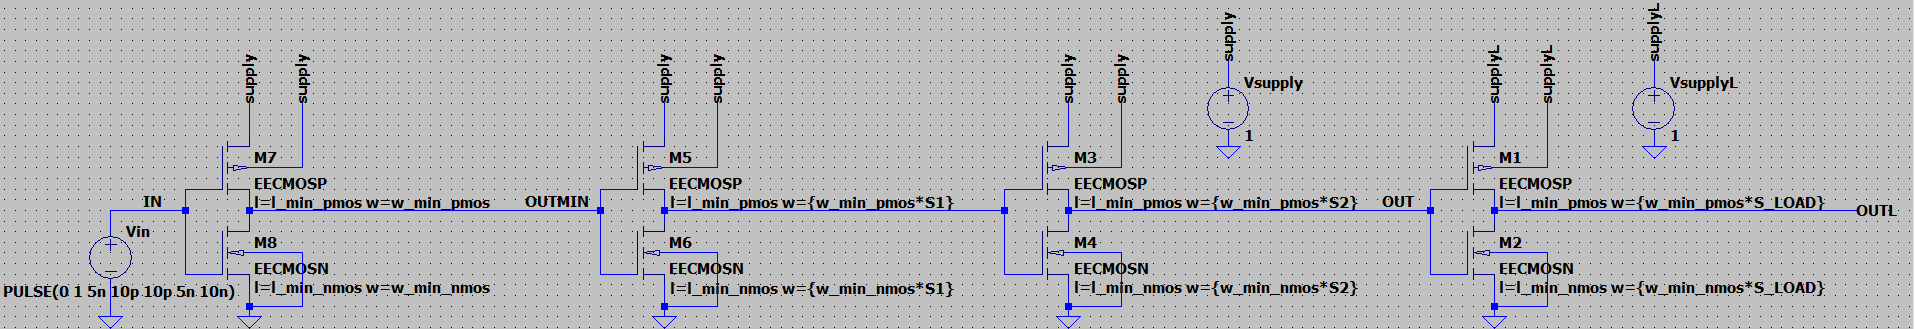

In [25]:
buffer_optimized_raw_file_path = os.path.join(ltspice, "buffer/optimized/buffer_optimized.raw")
check_file(buffer_optimized_raw_file_path)
buffer_optimized_ltr = RawRead(buffer_optimized_raw_file_path)

buffer_optimized_asc_file_path = os.path.join(ltspice, "buffer/optimized/buffer_optimized.asc")
check_file(buffer_optimized_asc_file_path)
buffer_optimized_netlist = SpiceEditor(buffer_optimized_asc_file_path)

buffer_optimized_image_path = os.path.join(images, "buffer_optimized.png")
display(Image(buffer_optimized_image_path))

In [26]:
n_runs_optimized = ((d_max - d_min)/step) + 1

tmp_s1_from_matlab = [(str(var1)+"," if var1!=s1_from_matlab[len(s1_from_matlab)-1] else str(var1)) for var1 in s1_from_matlab]
s1_table_optimized_from_matlab = ""
for item in tmp_s1_from_matlab:
    s1_table_optimized_from_matlab = s1_table_optimized_from_matlab + item
tmp_s2_from_matlab = [(str(var2)+"," if var2!=s2_from_matlab[len(s2_from_matlab)-1] else str(var2)) for var2 in s2_from_matlab]
s2_table_optimized_from_matlab = ""
for item in tmp_s2_from_matlab:
    s2_table_optimized_from_matlab = s2_table_optimized_from_matlab + item

S1_optimized = f' table(index,{s1_table_optimized_from_matlab})'
print(S1_optimized)
S2_optimized = f' table(index,{s2_table_optimized_from_matlab})'
print(S2_optimized)

buffer_optimized_netlist.set_parameter('l_min_pmos', l_min_pmos)
buffer_optimized_netlist.set_parameter('w_min_pmos', w_min_pmos)
buffer_optimized_netlist.set_parameter('l_min_nmos', l_min_nmos)
buffer_optimized_netlist.set_parameter('w_min_nmos', w_min_nmos)
buffer_optimized_netlist.set_parameter('S1', S1_optimized)
buffer_optimized_netlist.set_parameter('S2', S2_optimized)
buffer_optimized_netlist.set_parameter('S_LOAD', S_LOAD)
buffer_optimized_netlist.add_instructions(
                                rit_models,
                                tran,
                                f".step param index 1 {n_runs_optimized} 1",
                                energy_connected(13,22),
                                rise_delay_connected(),
                                fall_delay_connected()
                        )
buffer_optimized_runner = SimRunner(output_folder="data/buffer/optimized/")
buffer_optimized_runner.run(buffer_optimized_netlist)

buffer_optimized_log = ""
for buffer_optimized_raw, buffer_optimized_log in buffer_optimized_runner:
    print("Raw file: %s, Log file: %s" % (buffer_optimized_raw, buffer_optimized_log))

 table(index,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.29568,1.645862,1.0,3.272149,1.0,1.0,1.0,1.0,3.639962,3.687)
 table(index,1.522233,1.558074,1.594455,1.631416,1.669031,1.705245,1.744604,1.785162,1.827207,1.871095,1.95611,1.893608,2.057649,2.078245,2.181277,2.183318,2.232473,2.534522,2.415108,2.568006,2.67192,2.808308,2.959713,3.130316,3.324425,3.566452,3.810408,4.182928,4.65833,5.299788,6.999738,7.071009,7.991315,6.808999,7.082803,15.15794,7.074697,6.539919,8.500874,7.071916,13.42104,13.36968)
Wed Nov  8 00:25:56 2023 info: RunTask #1:: Starting simulation 1
Wed Nov  8 00:26:02 2023 info: RunTask #1:Simulation Successful. Time elapsed: 05.0212 secs

Wed Nov  8 00:26:02 2023 info: RunTask #1:Simulation Finished. No Callback function given

Raw file: data\buffer\optimized\buffer_optimized_1.raw, Log file: data\buffer\optimized\buffer_optimized_1.log


In [27]:
buffer_optimized_log_file_path = f"./{buffer_optimized_log}"

with open(buffer_optimized_log_file_path, "r") as file:
    content = file.read()

energy_connected_buffer_optimized_data = re.search(energy_connected_pattern, content, re.DOTALL).group(1)
rise_delay_connected_buffer_optimized_data = re.search(rise_delay_connected_pattern, content, re.DOTALL).group(1)
fall_delay_connected_buffer_optimized_data = re.search(fall_delay_connected_pattern, content, re.DOTALL).group(1)

energy_connected_buffer_optimized_lines = energy_connected_buffer_optimized_data.strip().split('\n')[1:]
rise_delay_connected_buffer_optimized_lines = rise_delay_connected_buffer_optimized_data.strip().split('\n')[1:]
fall_delay_connected_buffer_optimized_lines = fall_delay_connected_buffer_optimized_data.strip().split('\n')[1:]

energy_connected_buffer_optimized = [float(line.split('\t')[1]) for line in energy_connected_buffer_optimized_lines]
energy_connected_buffer_optimized = [abs(energy) for energy in energy_connected_buffer_optimized]
rise_delay_connected_buffer_optimized = [float(line.split('\t')[1]) for line in rise_delay_connected_buffer_optimized_lines]
fall_delay_connected_buffer_optimized = [float(line.split('\t')[1]) for line in fall_delay_connected_buffer_optimized_lines]
delay_connected_buffer_optimized = rise_delay_connected_buffer_optimized

File updated successfully: ../../images/energy_delay_curve.png


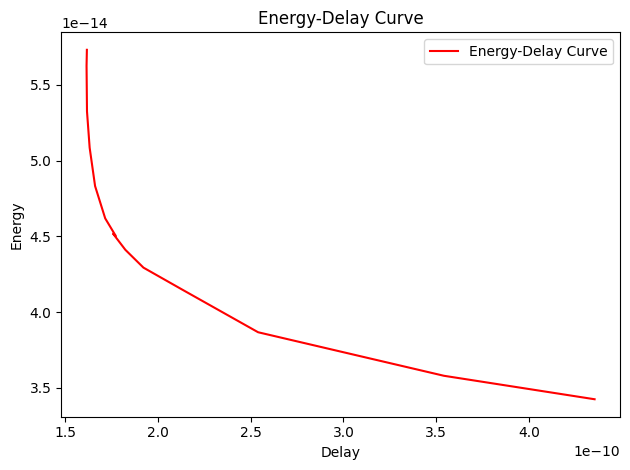

In [28]:
plt.plot(delay_connected_buffer_optimized, energy_connected_buffer_optimized, color='red')
plt.xlabel('Delay'); plt.ylabel('Energy'); plt.title('Energy-Delay Curve')
plt.tight_layout()
plt.legend(["Energy-Delay Curve"])
energy_delay_curve_path_image = os.path.join(images, "energy_delay_curve.png")
check_image(energy_delay_curve_path_image)
plt.savefig(energy_delay_curve_path_image)
plt.show()

File updated successfully: ../../images/comparative_analysis.png


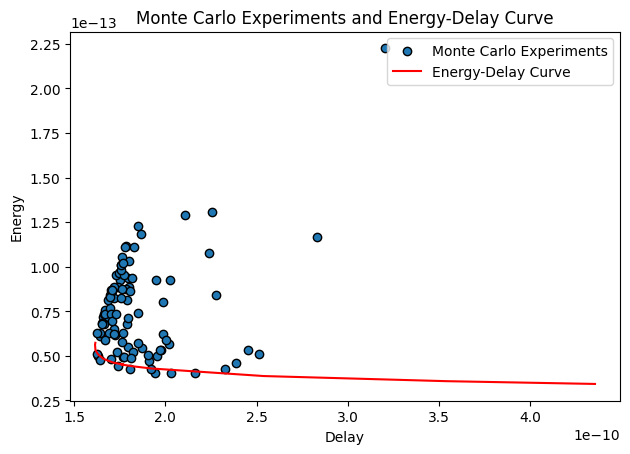

In [29]:
plt.scatter(delay_connected_buffer, energy_connected_buffer, edgecolors='black')
plt.plot(delay_connected_buffer_optimized, energy_connected_buffer_optimized, color='red')
plt.xlabel('Delay'); plt.ylabel('Energy'); plt.title('Monte Carlo Experiments and Energy-Delay Curve')
plt.tight_layout()
plt.legend(["Monte Carlo Experiments", "Energy-Delay Curve"])
comparative_analysis_path_image = os.path.join(images, "comparative_analysis.png")
check_image(comparative_analysis_path_image)
plt.savefig(comparative_analysis_path_image)
plt.show()